In [0]:
import os
from datetime import datetime
from statsmodels.datasets import co2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fastprogress import progress_bar as pb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [0]:
pd.plotting.register_matplotlib_converters()

In [0]:
df = co2.load_pandas().data

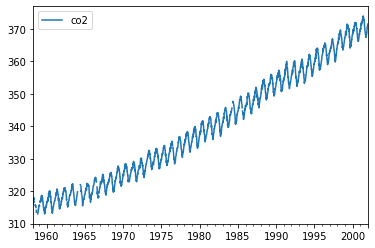

In [57]:
df.plot()

In [0]:
df.fillna(method='ffill', inplace=True)

In [59]:
df.isnull().sum()

co2    0
dtype: int64

In [0]:
ss = MinMaxScaler()

df = pd.DataFrame(
    data=ss.fit_transform(df),
    index=df.index,
    columns=df.columns
)

In [0]:
for i in range(100):
    df[f'lag{i+1}'] = df['co2'].shift(i+1)

In [62]:
df

co2      lag1      lag2  ...     lag98     lag99    lag100
1958-03-29  0.050903       NaN       NaN  ...       NaN       NaN       NaN
1958-04-05  0.070608  0.050903       NaN  ...       NaN       NaN       NaN
1958-04-12  0.075534  0.070608  0.050903  ...       NaN       NaN       NaN
1958-04-19  0.073892  0.075534  0.070608  ...       NaN       NaN       NaN
1958-04-26  0.055829  0.073892  0.075534  ...       NaN       NaN       NaN
...              ...       ...       ...  ...       ...       ...       ...
2001-12-01  0.940887  0.940887  0.931034  ...  0.919540  0.911330  0.912972
2001-12-08  0.949097  0.940887  0.940887  ...  0.932677  0.919540  0.911330
2001-12-15  0.955665  0.949097  0.940887  ...  0.922824  0.932677  0.919540
2001-12-22  0.957307  0.955665  0.949097  ...  0.921182  0.922824  0.932677
2001-12-29  0.960591  0.957307  0.955665  ...  0.929392  0.921182  0.922824

[2284 rows x 101 columns]

In [0]:
df.dropna(how='any', inplace=True)

In [0]:
df_train = df[:'1990-01-01']
df_test = df['1990-01-01':]

In [65]:
df_train

co2      lag1      lag2  ...     lag98     lag99    lag100
1960-02-27  0.065681  0.072250  0.064039  ...  0.075534  0.070608  0.050903
1960-03-05  0.064039  0.065681  0.072250  ...  0.073892  0.075534  0.070608
1960-03-12  0.077176  0.064039  0.065681  ...  0.055829  0.073892  0.075534
1960-03-19  0.082102  0.077176  0.064039  ...  0.064039  0.055829  0.073892
1960-03-26  0.077176  0.082102  0.077176  ...  0.064039  0.064039  0.055829
...              ...       ...       ...  ...       ...       ...       ...
1989-12-02  0.640394  0.630542  0.633826  ...  0.610837  0.610837  0.602627
1989-12-09  0.642036  0.640394  0.630542  ...  0.619048  0.610837  0.610837
1989-12-16  0.646962  0.642036  0.640394  ...  0.627258  0.619048  0.610837
1989-12-23  0.648604  0.646962  0.642036  ...  0.637110  0.627258  0.619048
1989-12-30  0.663383  0.648604  0.646962  ...  0.628900  0.637110  0.627258

[1558 rows x 101 columns]

In [66]:
df_test

co2      lag1      lag2  ...     lag98     lag99    lag100
1990-01-06  0.663383  0.663383  0.648604  ...  0.632184  0.628900  0.637110
1990-01-13  0.665025  0.663383  0.663383  ...  0.648604  0.632184  0.628900
1990-01-20  0.669951  0.665025  0.663383  ...  0.653530  0.648604  0.632184
1990-01-27  0.671593  0.669951  0.665025  ...  0.637110  0.653530  0.648604
1990-02-03  0.674877  0.671593  0.669951  ...  0.635468  0.637110  0.653530
...              ...       ...       ...  ...       ...       ...       ...
2001-12-01  0.940887  0.940887  0.931034  ...  0.919540  0.911330  0.912972
2001-12-08  0.949097  0.940887  0.940887  ...  0.932677  0.919540  0.911330
2001-12-15  0.955665  0.949097  0.940887  ...  0.922824  0.932677  0.919540
2001-12-22  0.957307  0.955665  0.949097  ...  0.921182  0.922824  0.932677
2001-12-29  0.960591  0.957307  0.955665  ...  0.929392  0.921182  0.922824

[626 rows x 101 columns]

In [0]:
for j in pb(range(2, 100)):
    feat_names = [f'lag{i+1}' for i in range(j)]

    df_train_x = df_train[feat_names]
    df_train_y = df_train[['co2']]

    df_test_x = df_test[feat_names]
    df_test_y = df_test[['co2']]

    params = {
        'C': np.logspace(0, 2, 10),
        'epsilon': np.logspace(-1, 1, 10)
    }

    gs = GridSearchCV(
        SVR(kernel='rbf'),
        params,
        cv=4,
        return_train_score=True
    )

    gs.fit(df_train_x, df_train_y.values.ravel())

    best_model = gs.best_estimator_

    pred = best_model.predict(df_test_x)

    df_test[f'pred_lag{j}'] = pred

In [68]:
df_test

co2      lag1      lag2  ...  pred_lag97  pred_lag98  pred_lag99
1990-01-06  0.663383  0.663383  0.648604  ...    0.575959    0.576229    0.576499
1990-01-13  0.665025  0.663383  0.663383  ...    0.577386    0.577599    0.577856
1990-01-20  0.669951  0.665025  0.663383  ...    0.578989    0.579164    0.579378
1990-01-27  0.671593  0.669951  0.665025  ...    0.580632    0.580843    0.581025
1990-02-03  0.674877  0.671593  0.669951  ...    0.582308    0.582505    0.582713
...              ...       ...       ...  ...         ...         ...         ...
2001-12-01  0.940887  0.940887  0.931034  ...    0.365026    0.365086    0.365143
2001-12-08  0.949097  0.940887  0.940887  ...    0.365037    0.365073    0.365116
2001-12-15  0.955665  0.949097  0.940887  ...    0.365023    0.365077    0.365097
2001-12-22  0.957307  0.955665  0.949097  ...    0.365002    0.365059    0.365096
2001-12-29  0.960591  0.957307  0.955665  ...    0.364998    0.365041    0.365081

[626 rows x 199 columns]

In [69]:
df_test[f'pred_lag19'].to_numpy().shape

(626,)

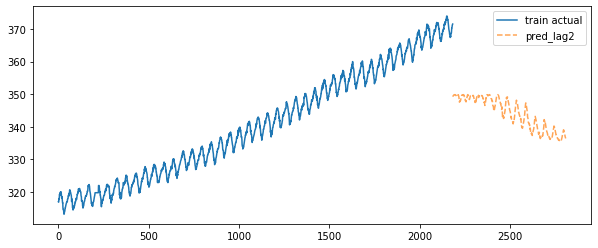

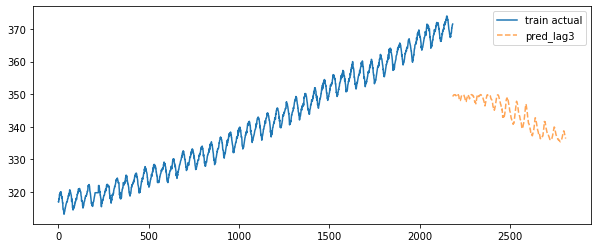

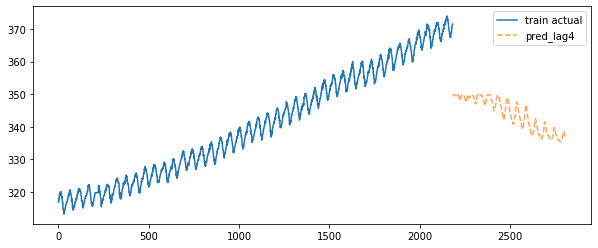

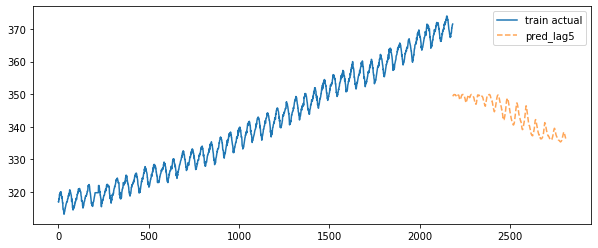

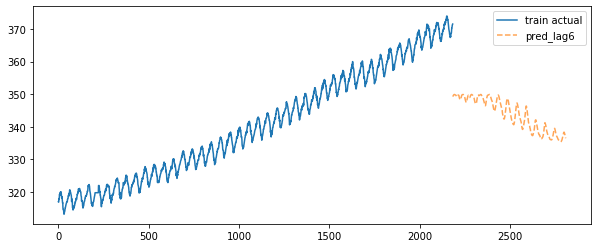

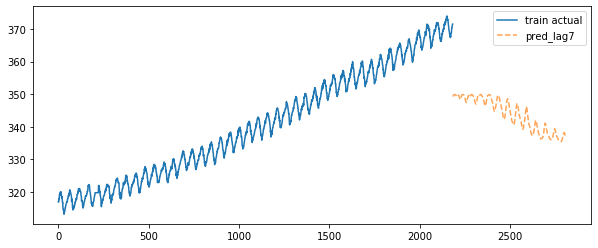

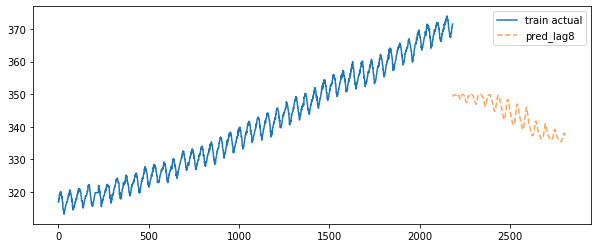

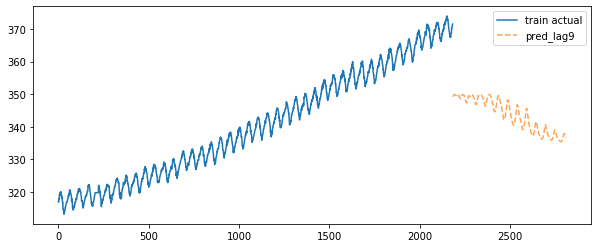

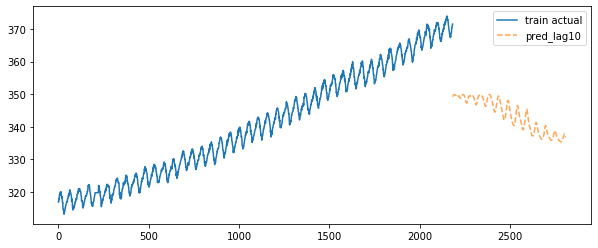

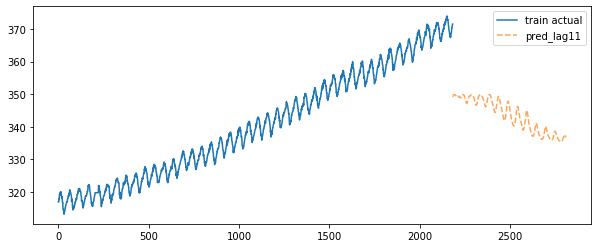

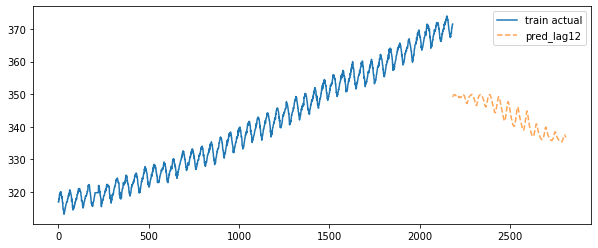

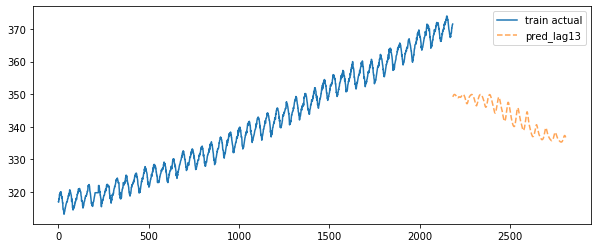

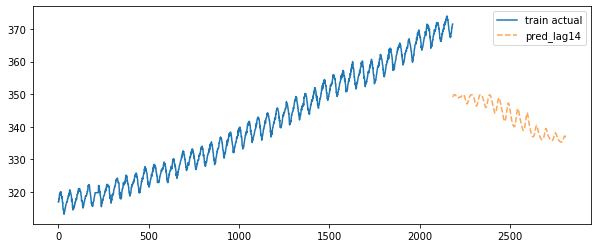

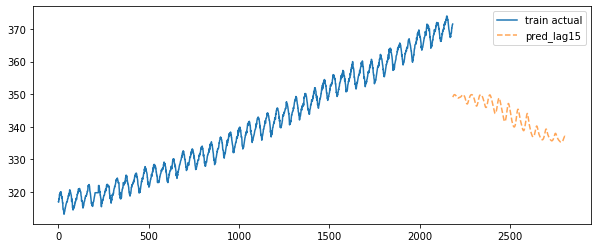

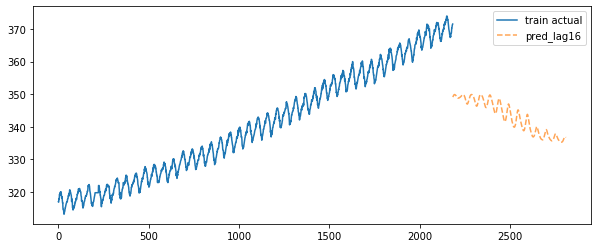

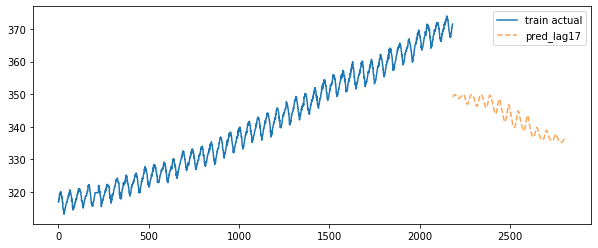

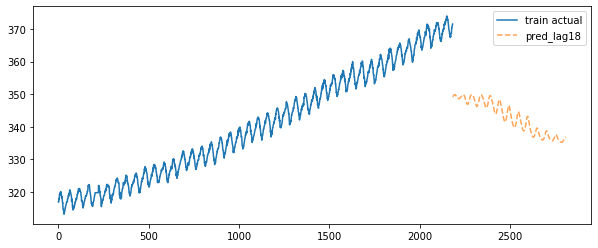

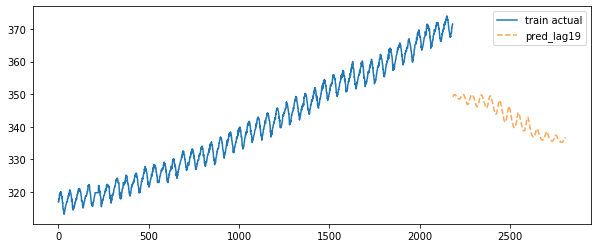

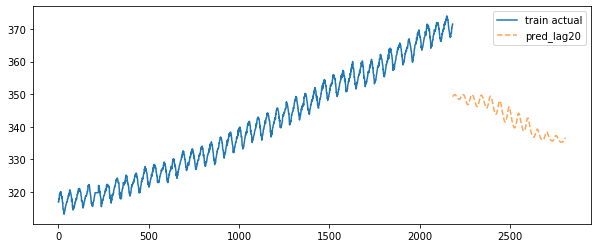

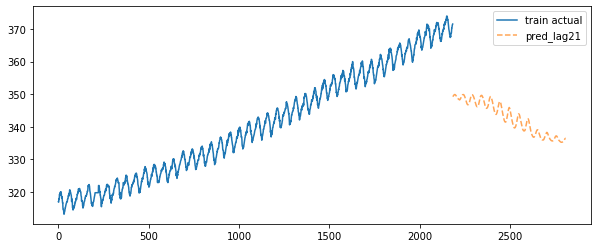

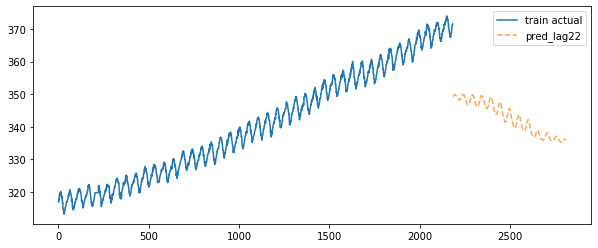

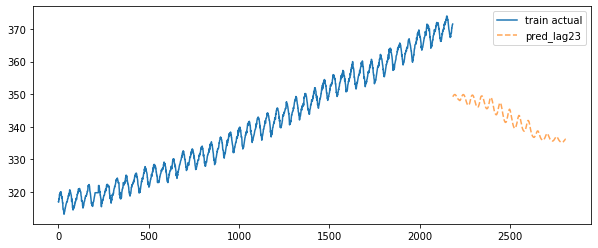

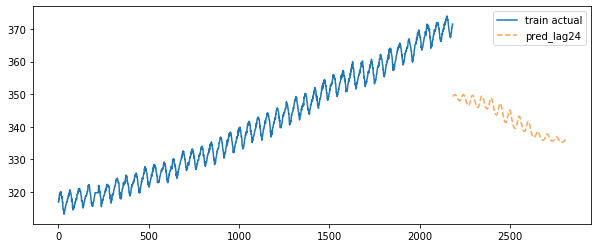

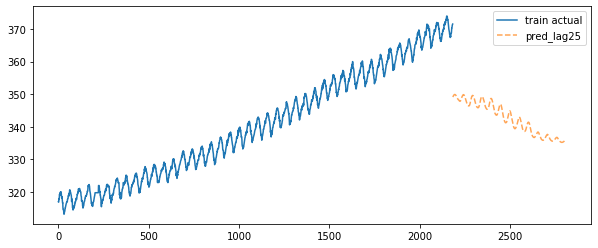

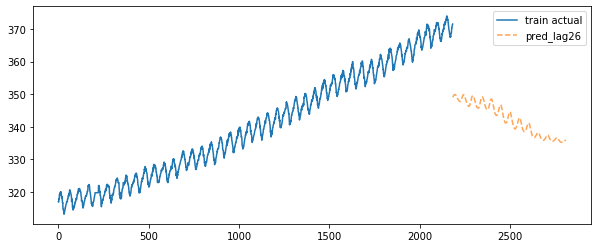

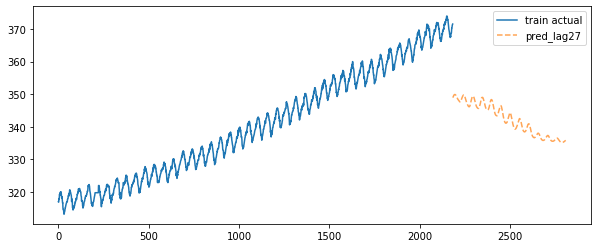

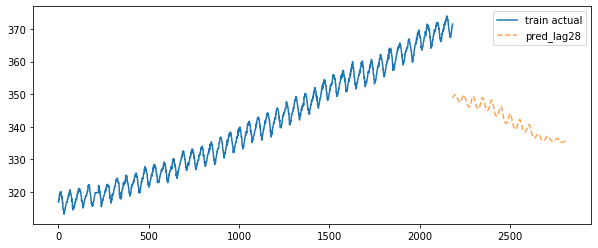

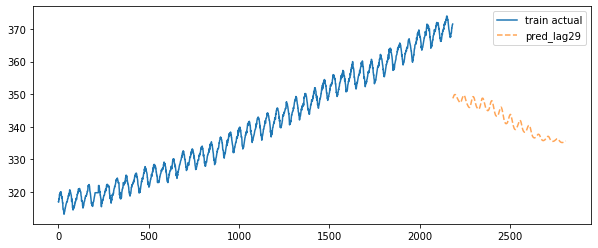

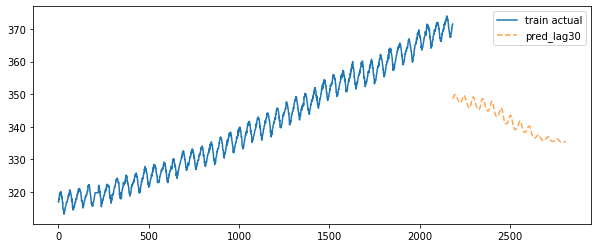

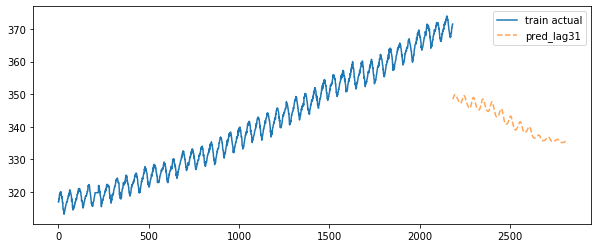

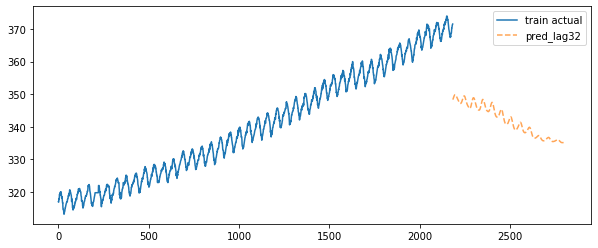

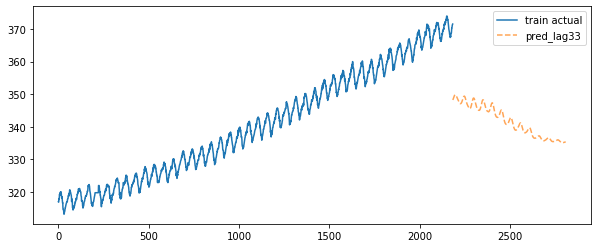

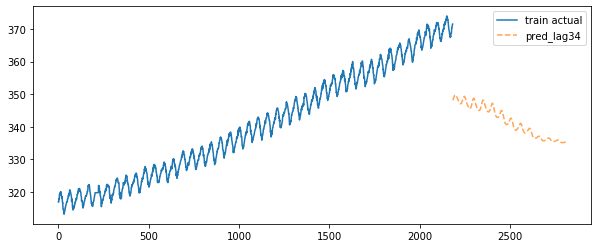

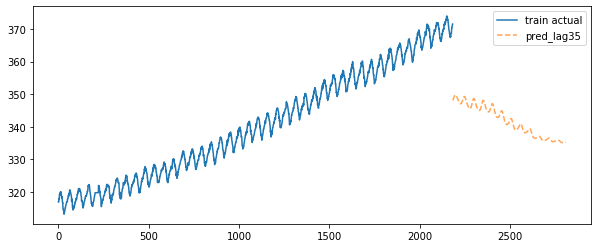

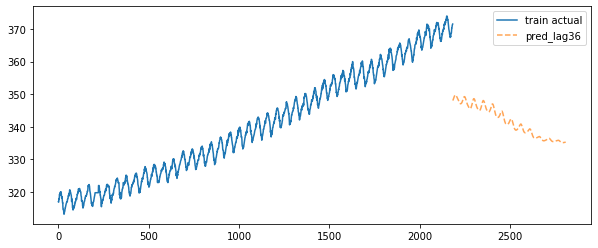

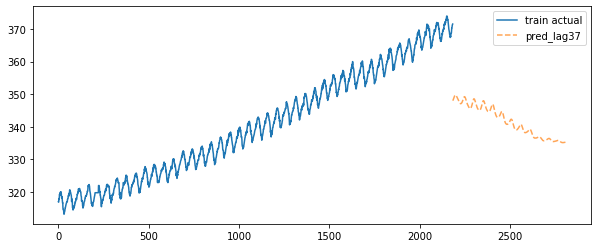

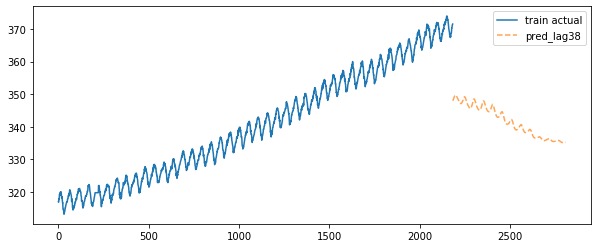

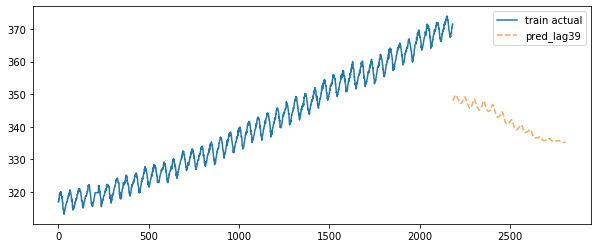

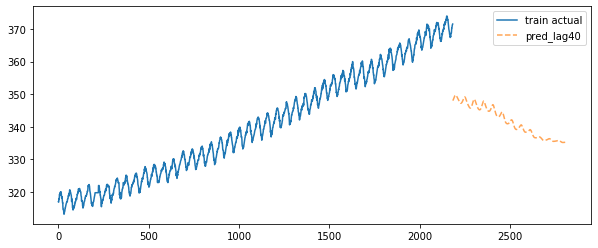

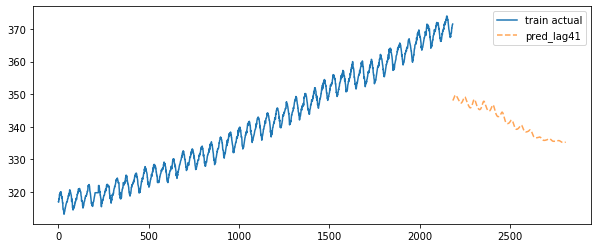

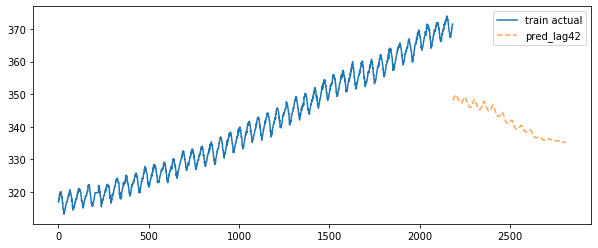

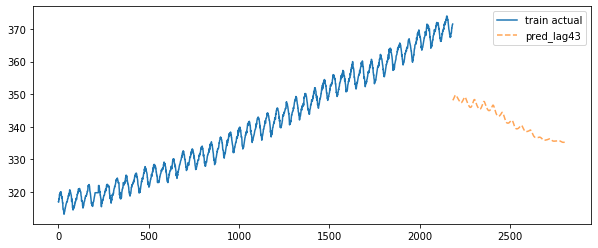

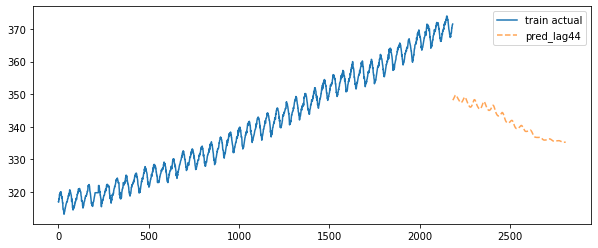

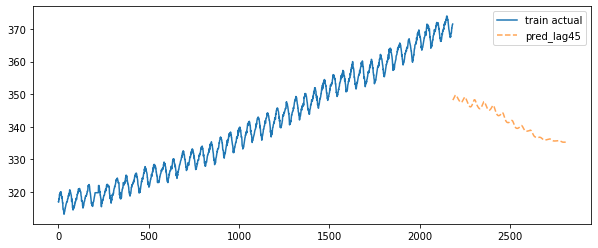

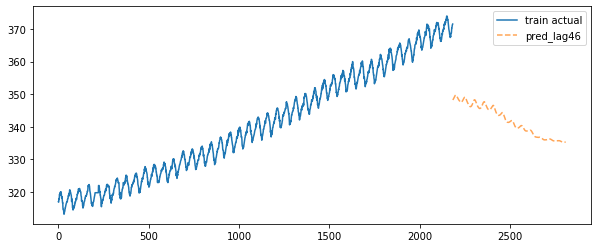

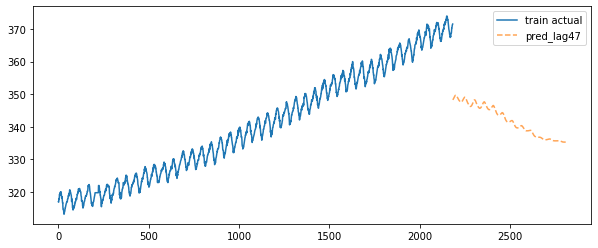

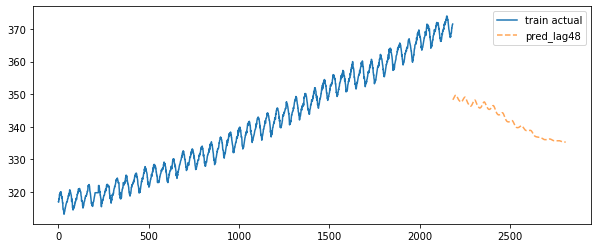

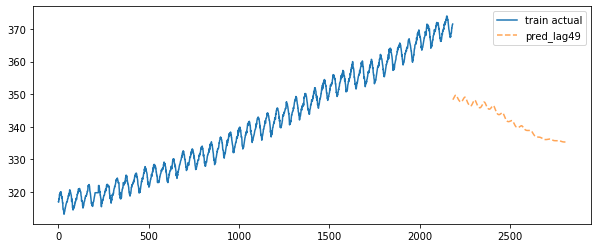

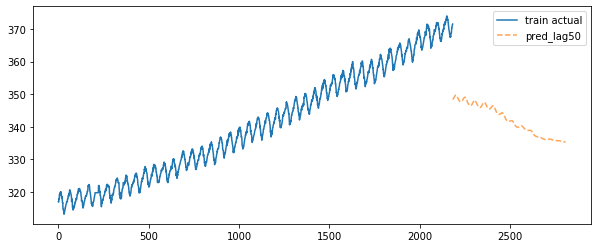

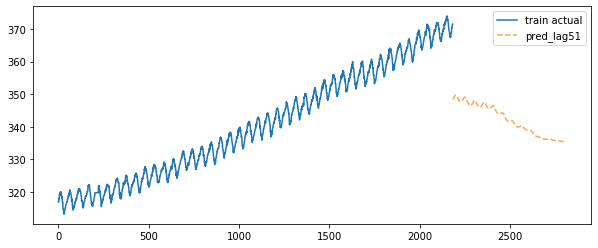

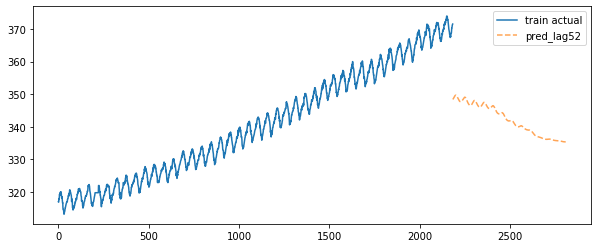

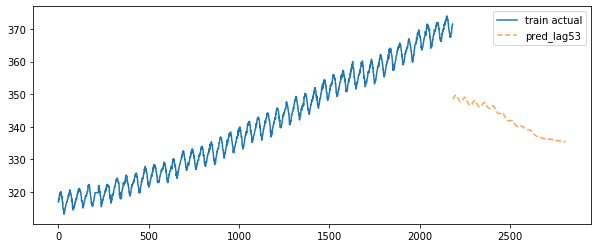

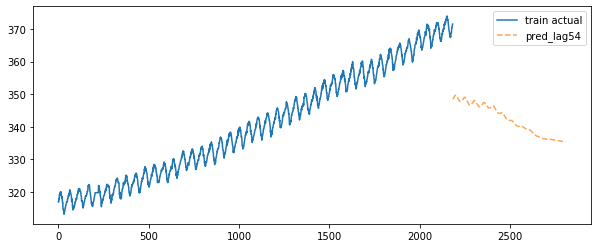

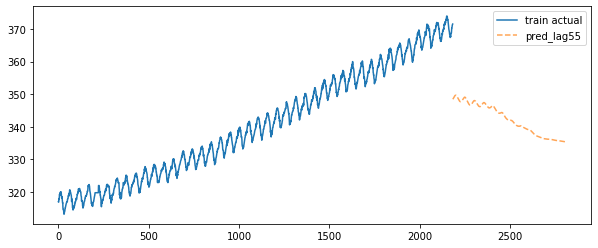

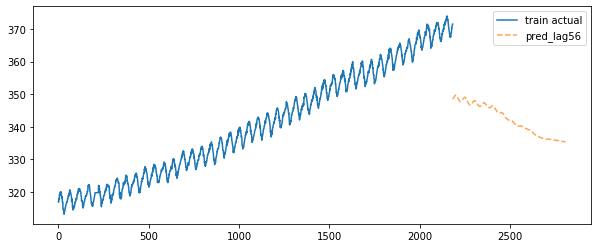

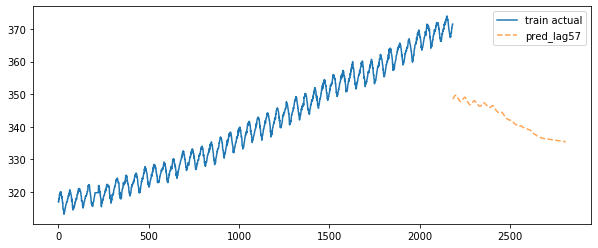

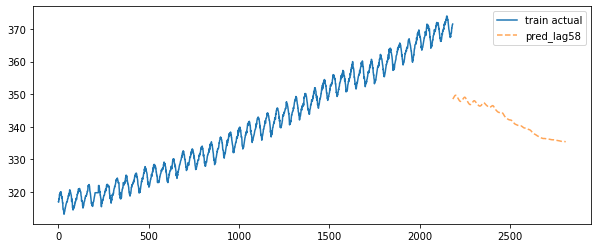

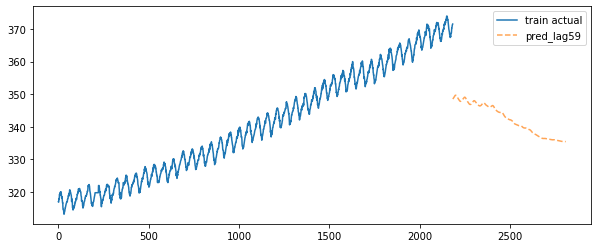

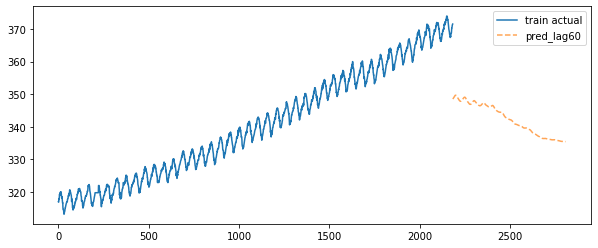

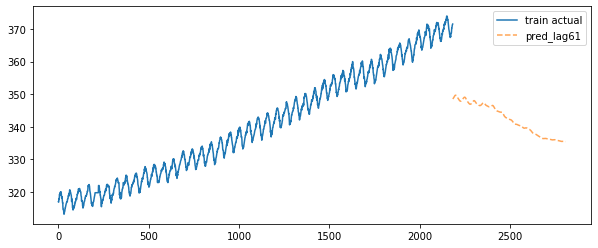

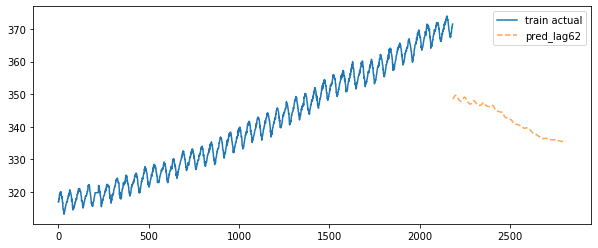

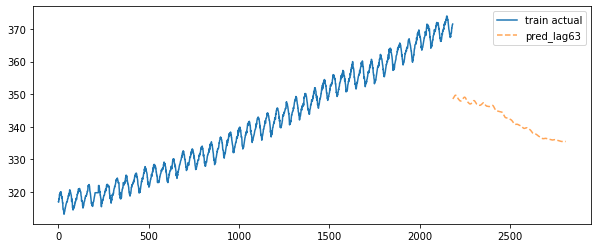

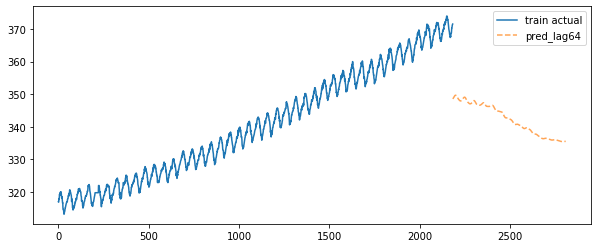

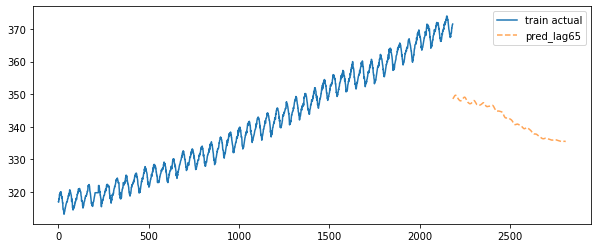

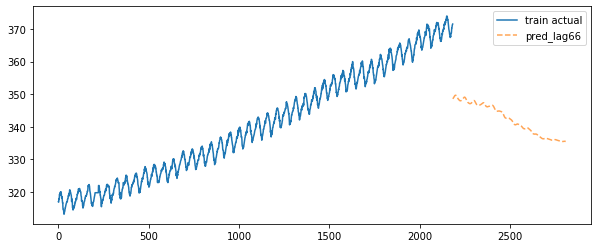

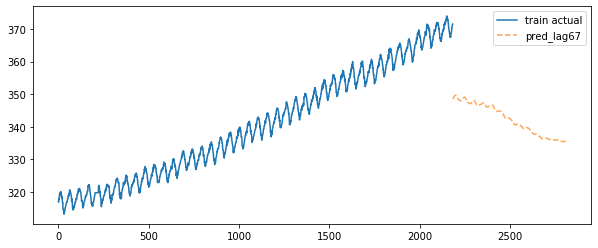

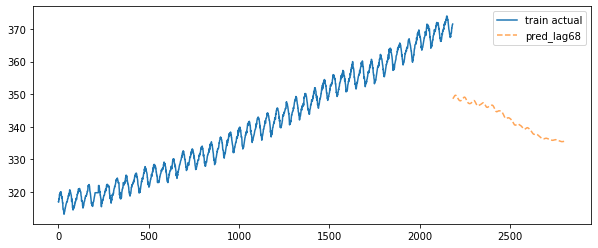

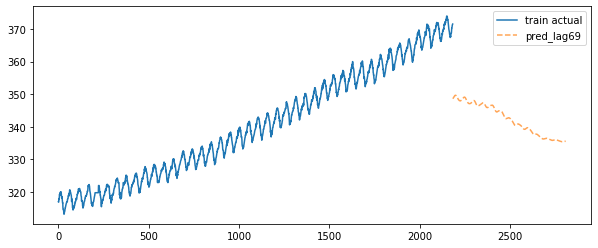

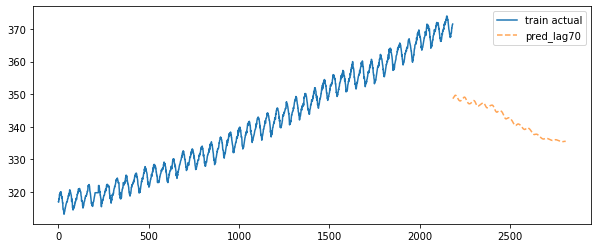

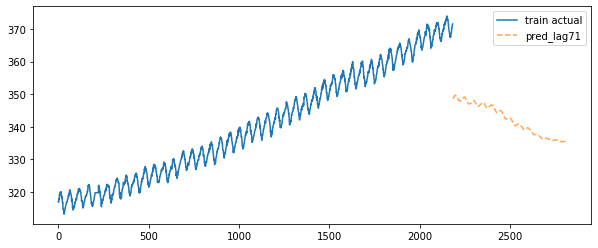

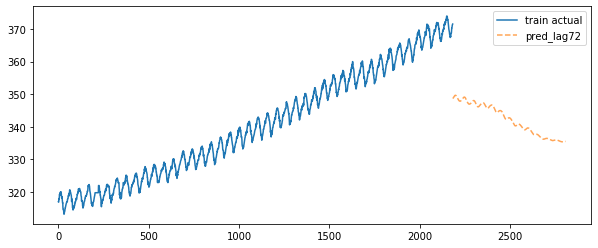

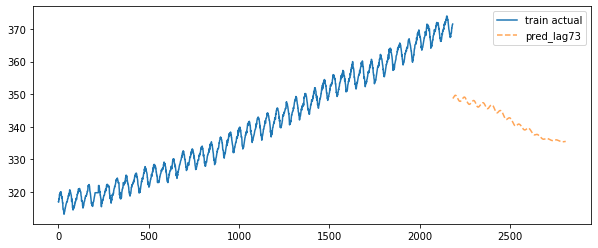

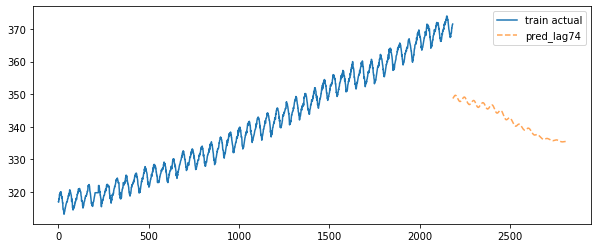

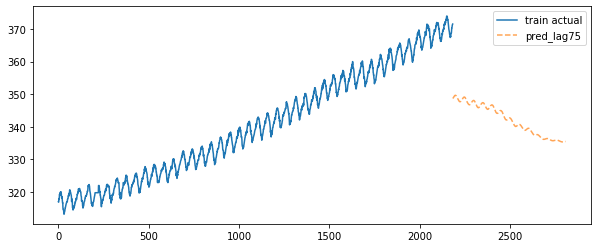

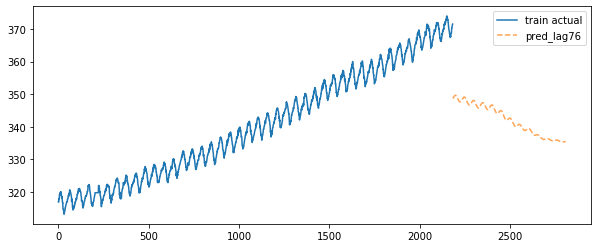

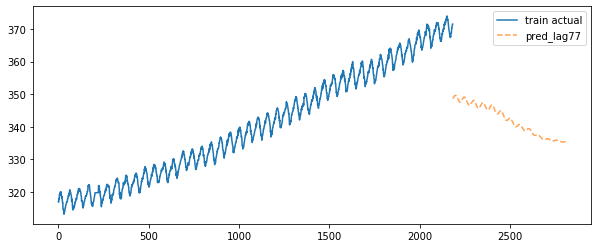

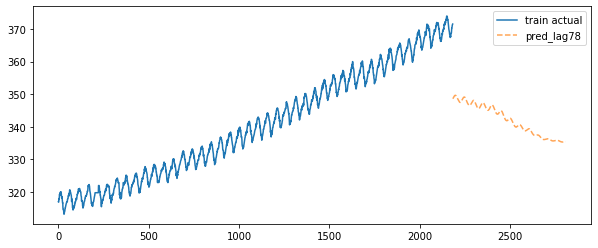

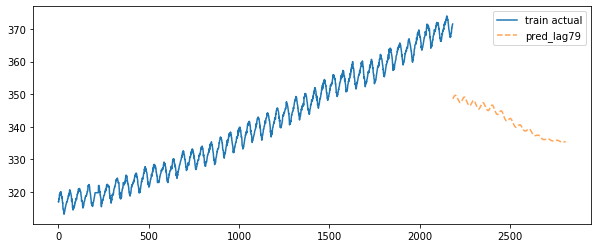

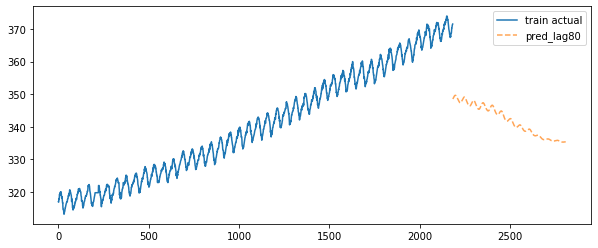

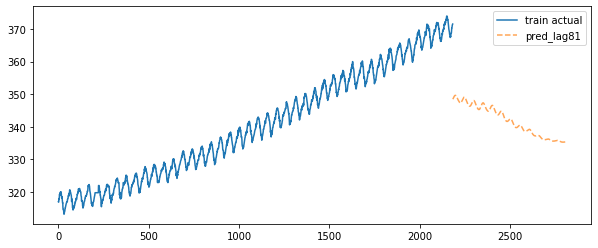

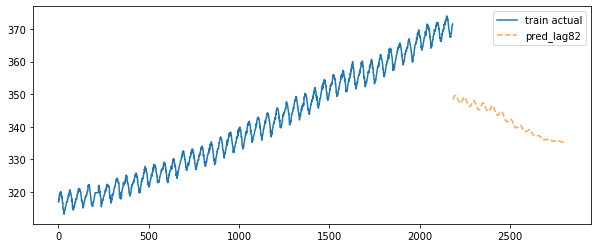

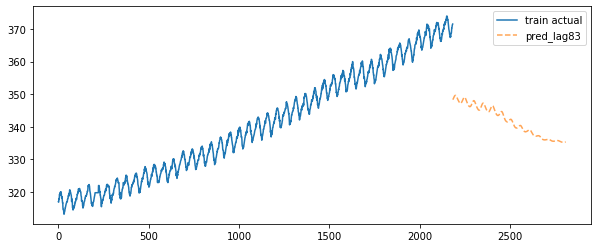

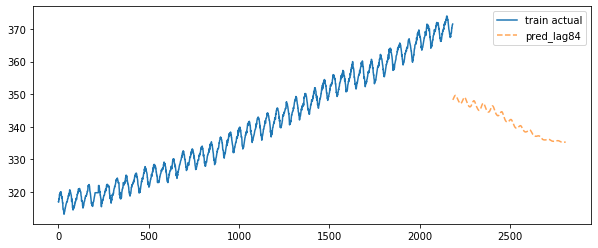

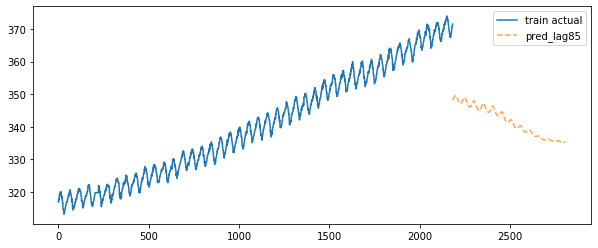

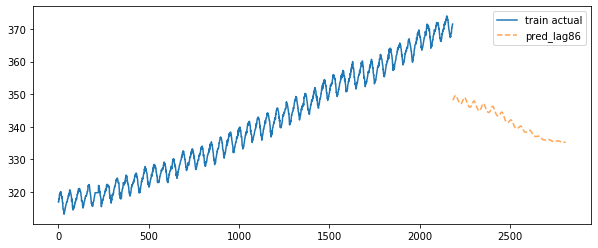

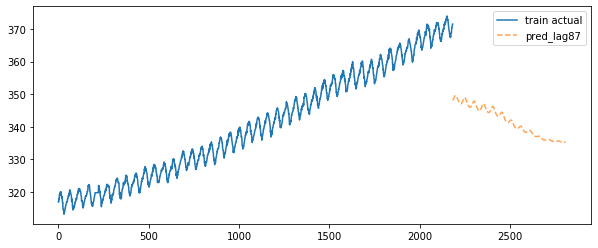

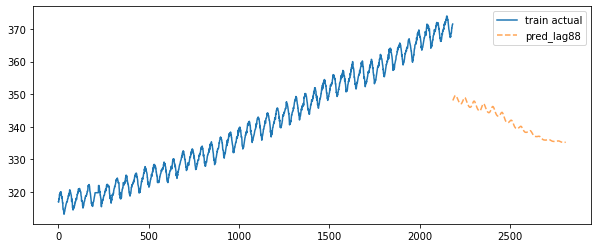

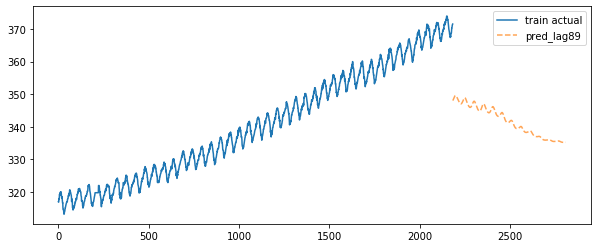

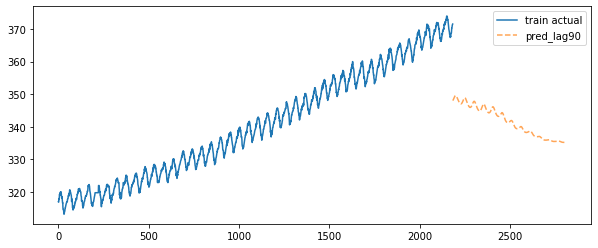

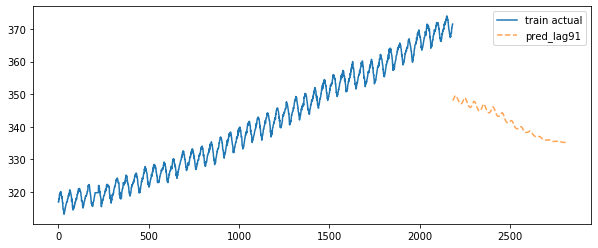

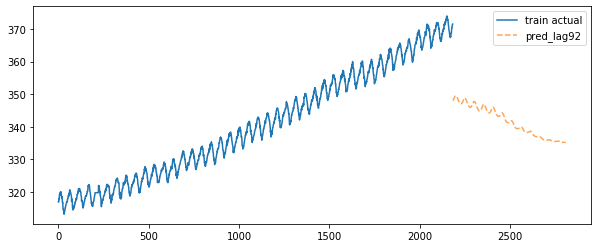

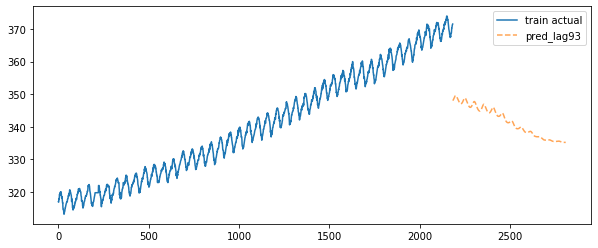

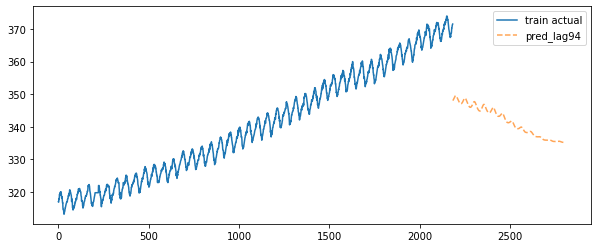

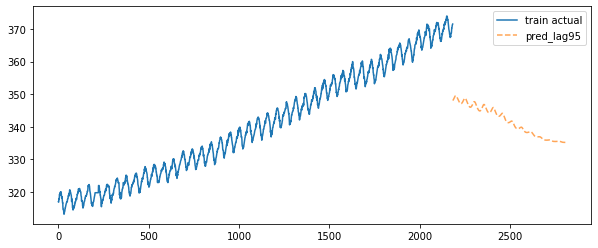

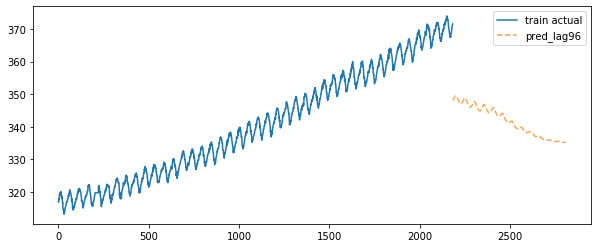

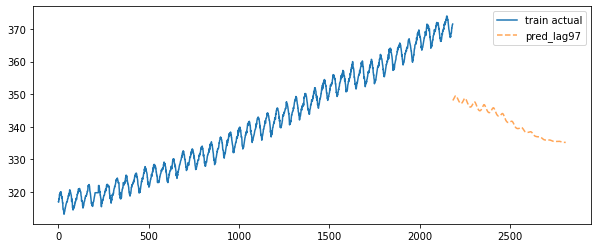

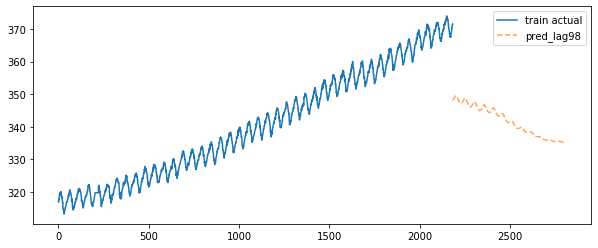

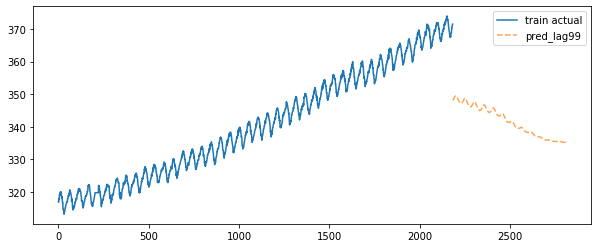

In [72]:
for i in range(2, 100):
    plt.figure(figsize=(10, 4))
    plt.plot(
        range(len(df['co2'])),
        ss.inverse_transform(df['co2'].to_numpy().reshape(-1, 1)).flatten(),
        label='train actual'
    )
    plt.plot(
        range(len(df['co2']), len(df['co2'])+len(df_test[f'pred_lag{i}'])),
        ss.inverse_transform(df_test[f'pred_lag{i}'].to_numpy().reshape(-1, 1)).flatten(),
        label=f'pred_lag{i}',
        linestyle='dashed',
        alpha=0.7,
    )
    plt.legend()
    plt.show()

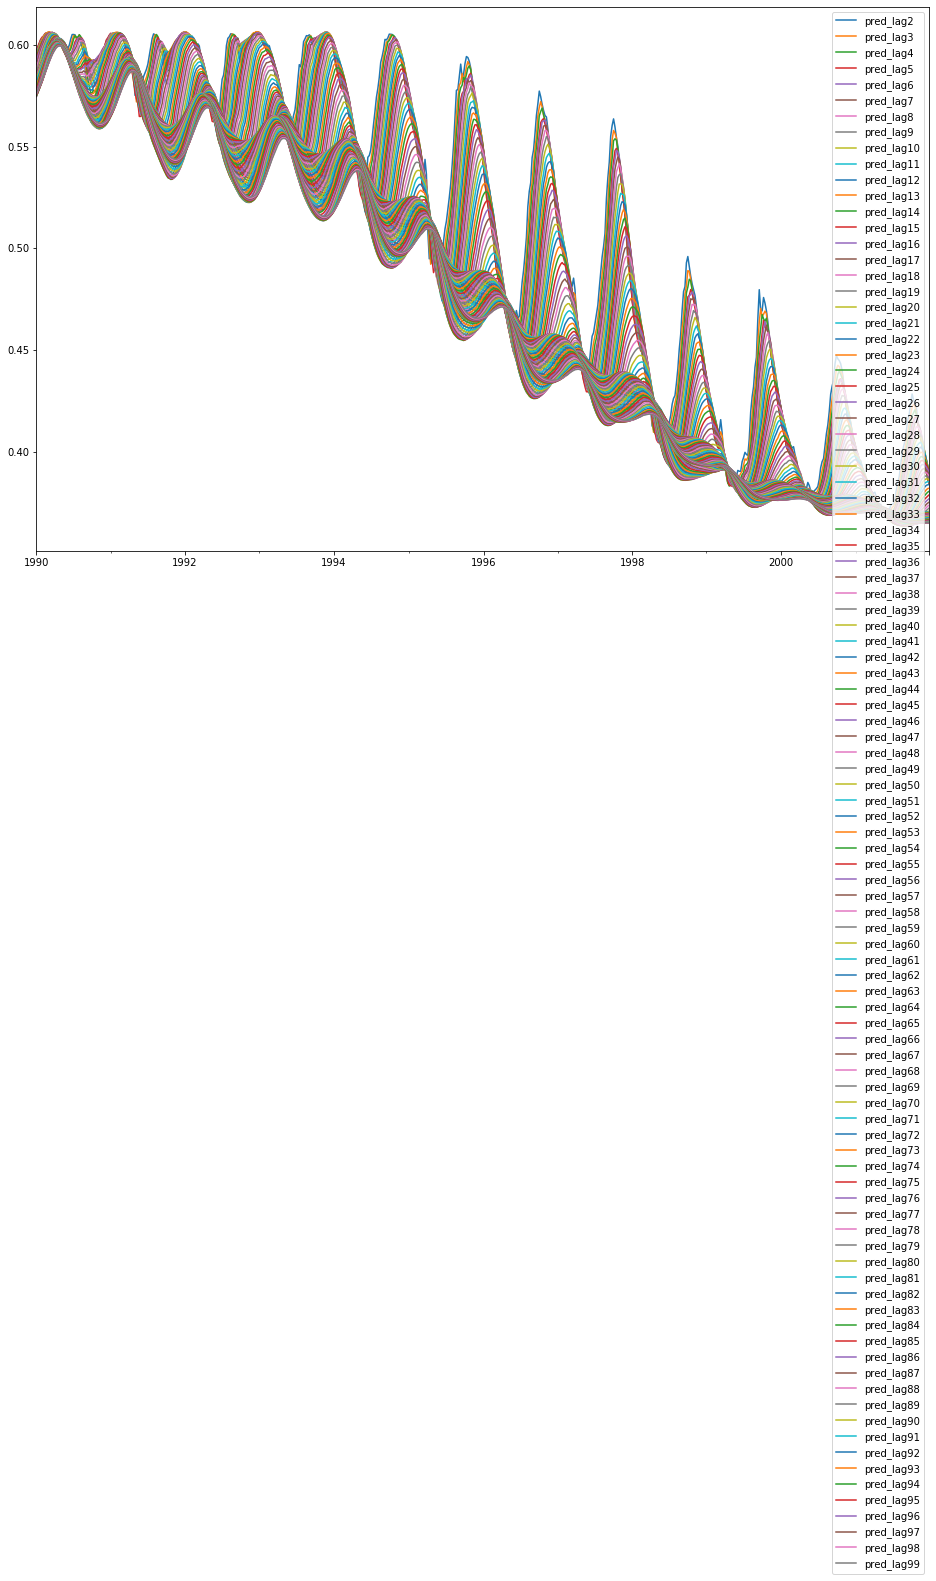

In [73]:
df_test[[f'pred_lag{i}' for i in range(2, 100)]].plot(figsize=(16, 10))